In [25]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv("Financial_Messy_Data.csv")


In [126]:
#Data Cleaning
df["Category"]=df["Category"].astype(str).str.strip().str.title()
df["Vendor"]=df["Vendor"].astype(str).str.strip().str.title()
df["Payment Method"]=df["Payment Method"].astype(str).str.strip().str.title()
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
df = df.dropna(subset=["Amount"])
df['Vendor'] = df['Vendor'].replace(['nan', 'Nan', '','<Na>'], pd.NA)
df['Vendor'] = df['Vendor'].fillna("Unknown")
df['Date'] = df['Date'].astype(str).str.strip()
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)
df['Date'] = df['Date'].dt.to_period('M')
df['Category'] = df['Category'].replace(['nan', 'Nan', ''], pd.NA)
df['Category'] = df['Category'].fillna("Other")


C:\Users\muham\AppData\Local\Temp\ipykernel_17152\1375403322.py:10: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)


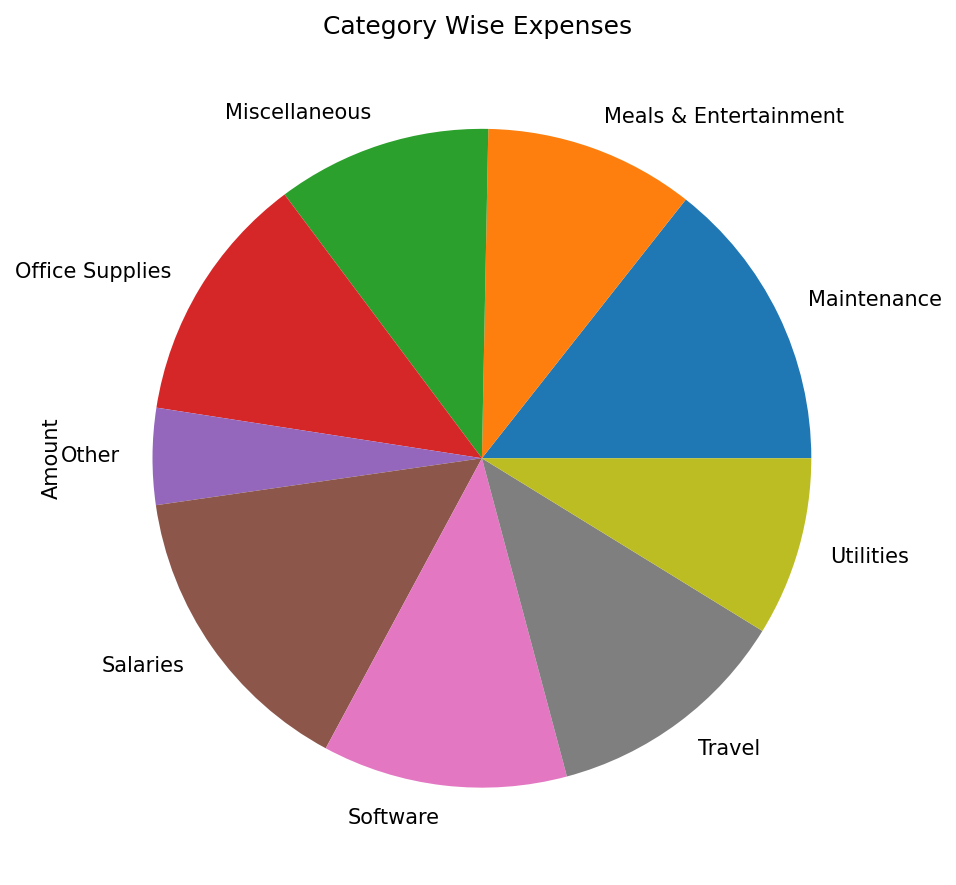

In [105]:
category_expenses = df.groupby('Category')['Amount'].sum()
plt.figure(figsize=(10,6),dpi =150)
category_expenses.plot(kind="pie")
plt.title("Category Wise Expenses ")
plt.savefig("Category Wise Expenses pie.png")
plt.tight_layout()

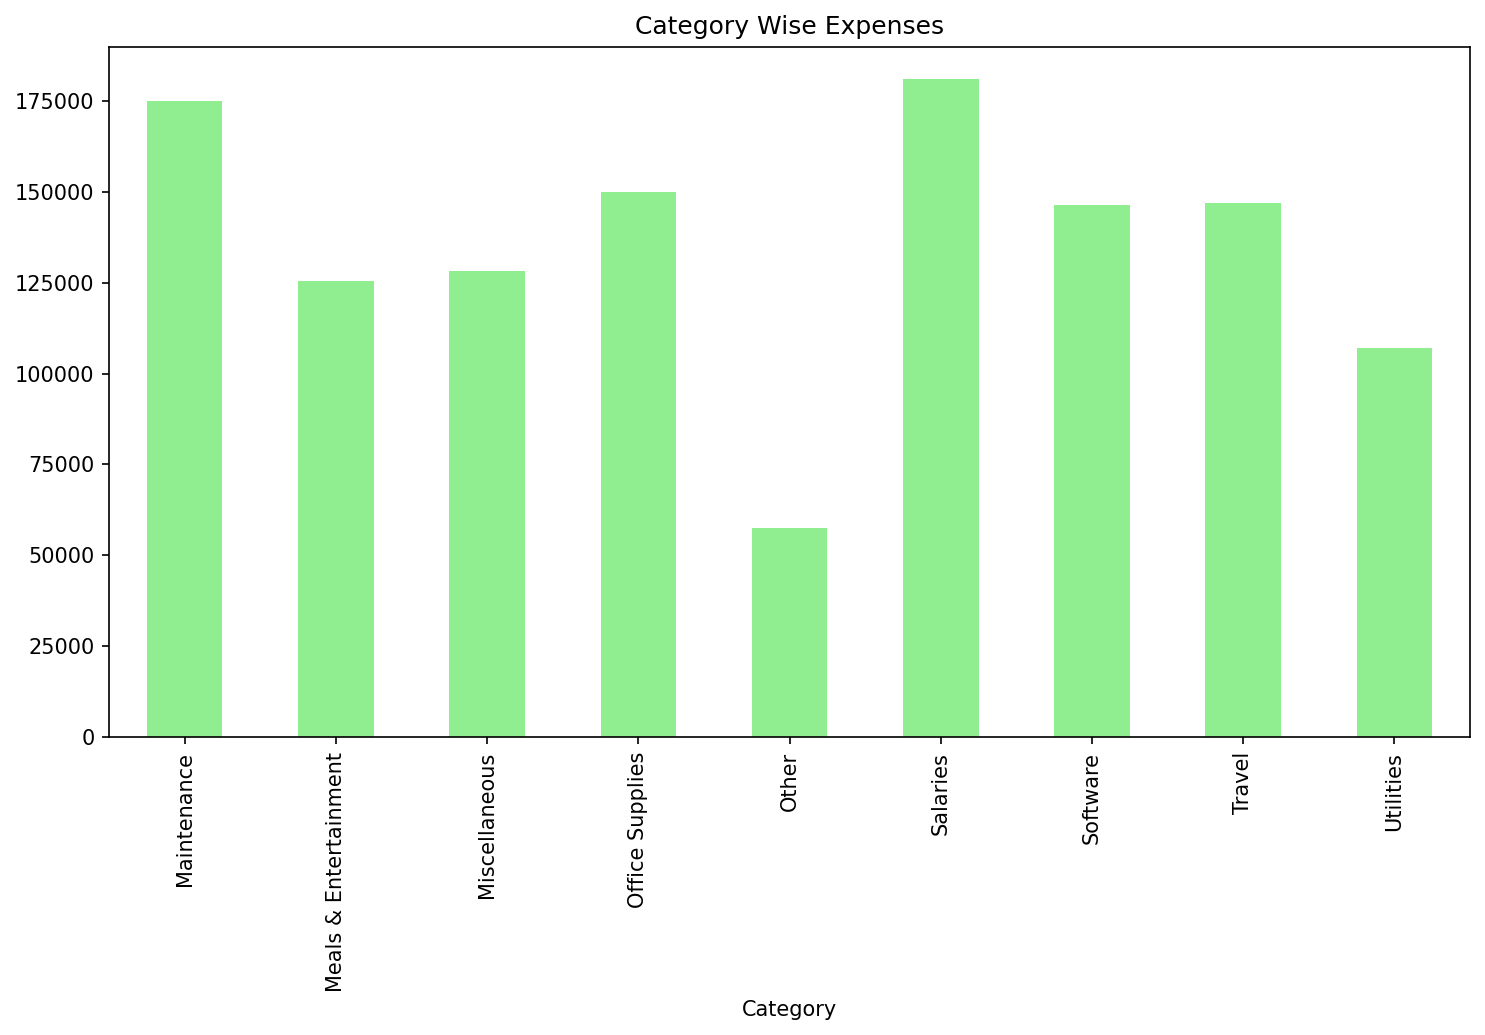

In [104]:
category_expenses = df.groupby('Category')['Amount'].sum()
plt.figure(figsize=(10,7),dpi =150)
category_expenses.plot(kind="bar", color="lightgreen")
plt.title("Category Wise Expenses")
plt.savefig('Category Wise Expenses.png') 
plt.tight_layout()

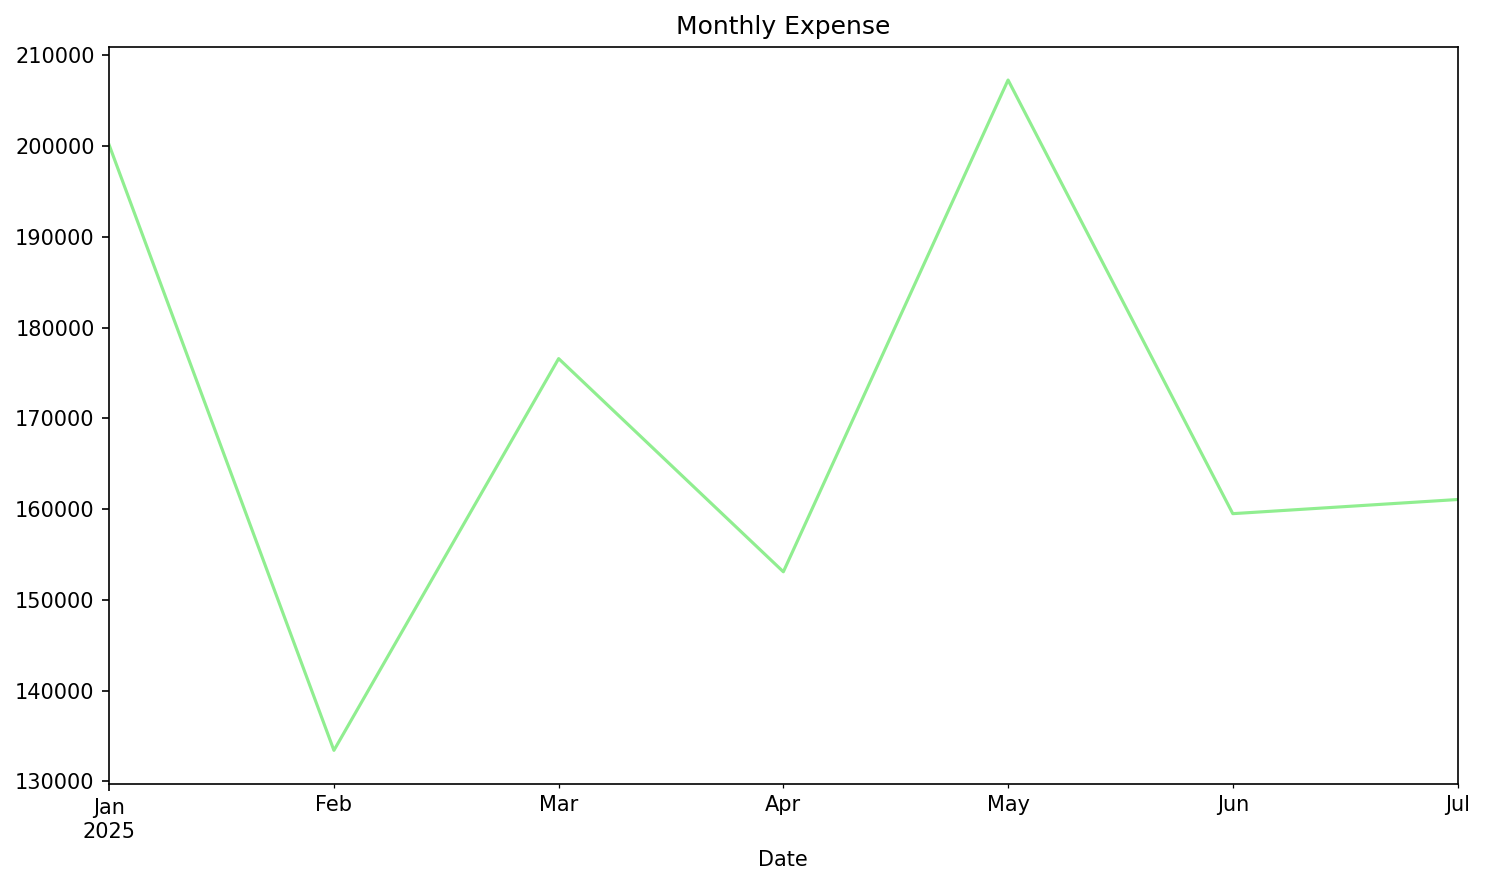

In [103]:
monthly_expenses =df.groupby("Date")["Amount"].sum()
plt.figure(figsize=(10,6),dpi = 150)
monthly_expenses.plot(kind="line", color="lightgreen")
plt.title("Monthly Expense")
plt.savefig('Monthly Expense.png')  

plt.tight_layout()


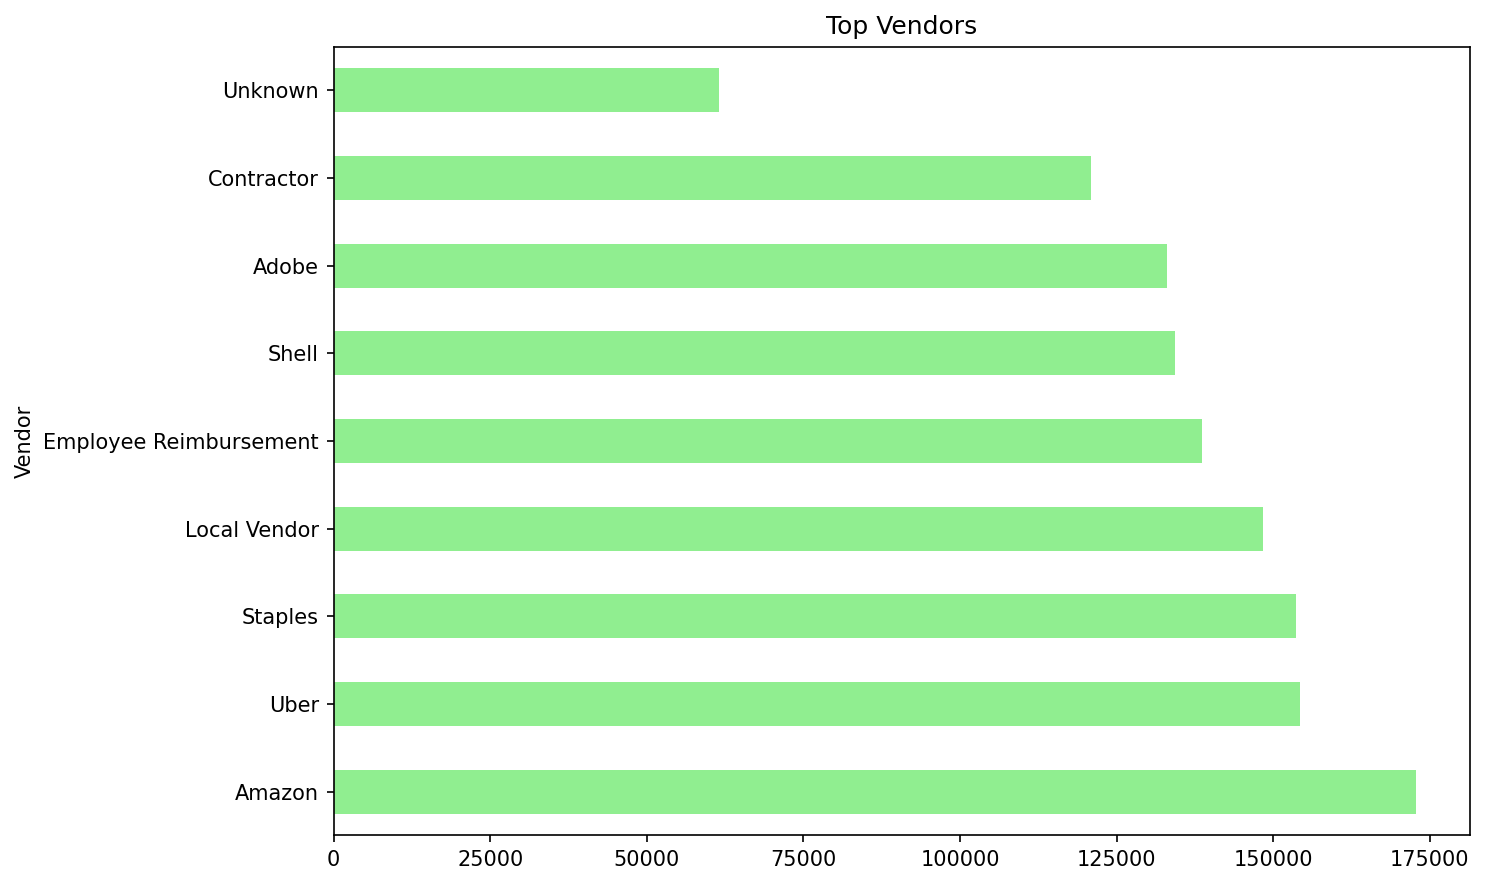

In [100]:
top_vendors = df.groupby("Vendor")["Amount"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6),dpi = 150)
top_vendors.plot(kind="barh", color="lightgreen")
plt.title("Top Vendors")
plt.savefig('Top Vendors.png')  

plt.tight_layout()

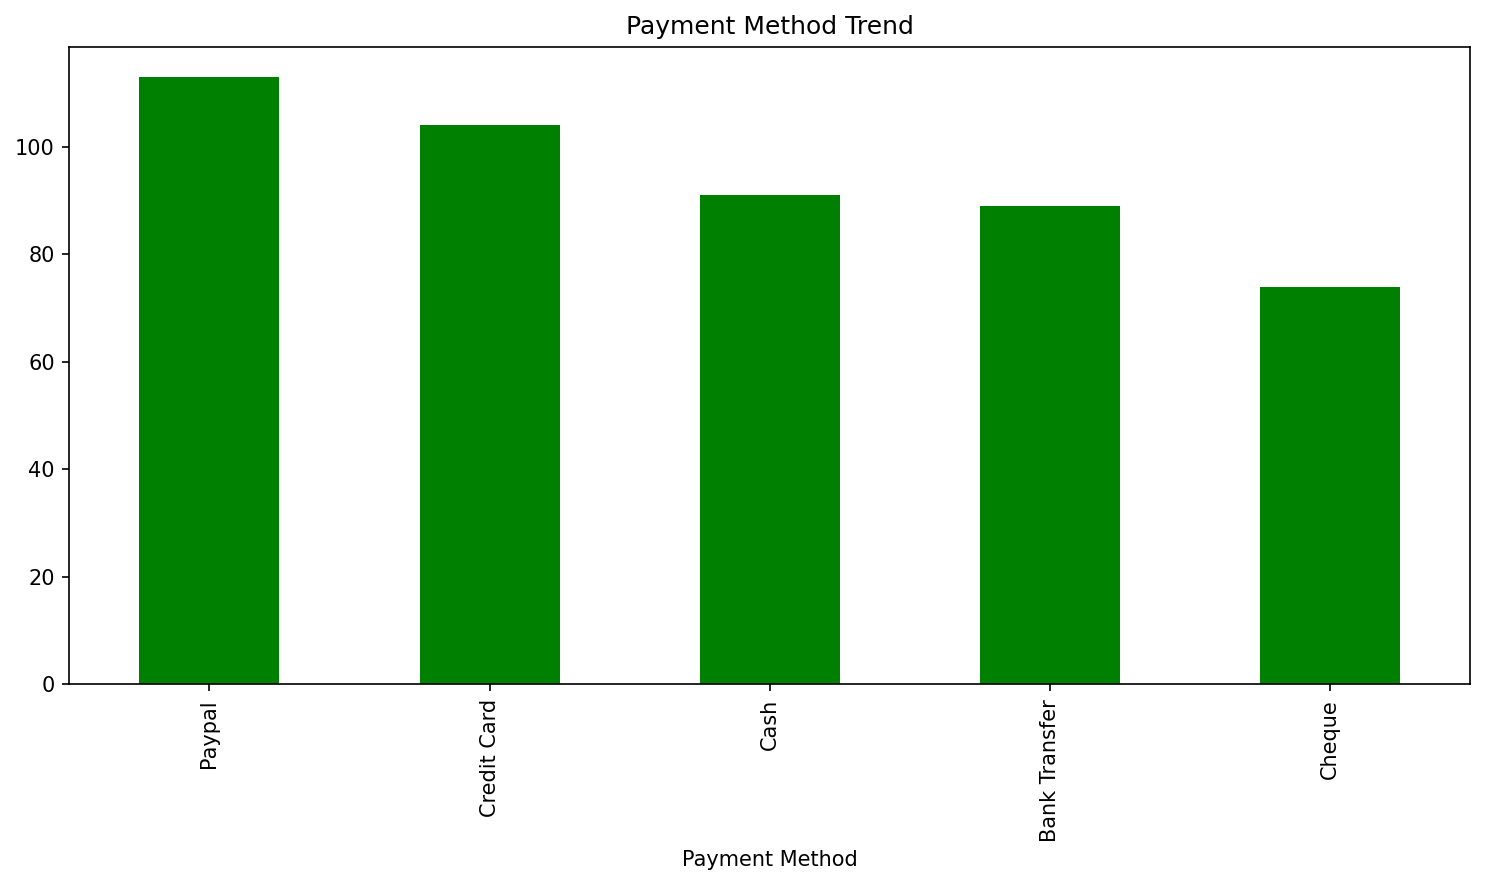

In [106]:
paymeny_method_counts = df["Payment Method"].value_counts()
plt.figure(figsize=(10,6),dpi = 150)
paymeny_method_counts.plot(kind="bar", color="green")
plt.title("Payment Method Trend")
plt.savefig('Payment Method Trend.png')  

plt.tight_layout()

In [93]:
high_value_txns = df[df['Amount'] > 3000].sort_values(by='Amount', ascending=False)


In [120]:
#checking
budget_thresholds = {
    'Office Supplies': 100000,
    'Travel': 120000,
    'Meals & Entertainment': 50000,
    'Maintenence': 200000,
    'Miscellenous': 5000,
    'Other': 5000,
    'Salaries':200000,
    'Software':150000,
    'Utility':10000,
}

category_spend = df.groupby('Category')['Amount'].sum()

for category, budget in budget_thresholds.items():
    actual = category_spend.get(category, 0)
    if actual > budget:
        print(f"Category {category} is OVER budget by ${actual - budget:.2f}")
    else:
        print(f"Category {category} is within budget.")

Category Office Supplies is OVER budget by $50001.60
Category Travel is OVER budget by $26857.96
Category Meals & Entertainment is OVER budget by $75571.21
Category Maintenence is within budget.
Category Miscellenous is within budget.
Category Other is OVER budget by $52632.98
Category Salaries is within budget.
Category Software is within budget.
Category Utility is within budget.


In [127]:

from openpyxl import Workbook
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows


category_spend = df.groupby('Category')['Amount'].sum()


budget_thresholds = {
    'Office Supplies': 100000,
    'Travel': 120000,
    'Meals & Entertainment': 50000,
    'Maintenance': 200000,
    'Miscellaneous': 5000,
    'Other': 5000,
    'Salaries': 200000,
    'Software': 150000,
    'Utilities': 10000,
}


wb = Workbook()


ws_dashboard = wb.active
ws_dashboard.title = "Dashboard"
ws_dashboard['A1'] = 'Financial Data Report'


images = [
    ('Payment Method Trend.png', 'A3'),
    ('Top Vendors.png', 'A30'),
    ('Monthly Expense.png', 'A57'),
    ('Category Wise Expenses.png', 'A84'),
    ('Category Wise Expenses pie.png', 'A111')
]

for img_path, cell in images:
    if os.path.exists(img_path):
        ws_dashboard.add_image(XLImage(img_path), cell)
    else:
        print(f"Image not found: {img_path}")


if 'Date' in df.columns:
    df['Date'] = df['Date'].astype(str)
ws_data = wb.create_sheet(title="Cleaned Data")

for r in dataframe_to_rows(df, index=False, header=True):
    ws_data.append(r)

ws_summary = wb.create_sheet(title="Summary Stats")

ws_summary['A1'] = 'Financial Data Summary Metrics'
ws_summary['A3'] = 'Total Records'
ws_summary['B3'] = len(df)
ws_summary['A4'] = 'Total Spend'
ws_summary['B4'] = round(df['Amount'].sum(), 2)
ws_summary['A5'] = 'Average Transaction Amount'
ws_summary['B5'] = round(df['Amount'].mean(), 2)

start_row = 8
ws_summary[f'A{start_row}'] = 'Category'
ws_summary[f'B{start_row}'] = 'Actual Spend'
ws_summary[f'C{start_row}'] = 'Budget Threshold'
ws_summary[f'D{start_row}'] = 'Status'

row = start_row + 1
for category, budget in budget_thresholds.items():
    actual = category_spend.get(category, 0)
    status = 'Over Budget' if actual > budget else 'Within Budget'
    over_under_value = actual - budget if actual > budget else budget - actual
    
    ws_summary[f'A{row}'] = category
    ws_summary[f'B{row}'] = round(actual, 2)
    ws_summary[f'C{row}'] = budget
    ws_summary[f'D{row}'] = f"{status} by ${abs(over_under_value):,.2f}"
    row += 1

wb.save('Financial_DATA.xlsx')
